In [74]:
import numpy as np
import igraph as ig 
import matplotlib.pyplot as plt
from pandas import DataFrame
from os import listdir

Helper Methods

In [140]:
# load all dataset names and graph data from "graphs" directory
def get_data(dir="graphs/"):
    files = sorted(listdir(dir))

    dataset_names = []
    wrong_graphs, correct_graphs = np.array([]), np.array([])

    for file in files:
        if file.endswith("wrong_graphs.npy"):
            dataset_names.append(file.replace("_wrong_graphs.npy", ""))

            data_wrong_graphs = np.load(dir+file, allow_pickle=True)
            wrong_graphs = np.append(wrong_graphs, data_wrong_graphs)

        if file.endswith("right_graphs.npy"):
            data_right_graphs = np.load(dir+file, allow_pickle=True)
            correct_graphs = np.append(correct_graphs, data_right_graphs)

    return dataset_names, wrong_graphs, correct_graphs


In [101]:
# dict maps a dataset:str to an numpy array which contains cna values

dataset_to_metrics = {}


def get_cna_metrics(data: np.ndarray):
    dataset_to_metrics = {}

    array = np.zeros((len(data), 8))

    # maps the index of array to the metric name (needed to label automatically in visualization)
    index_to_metric = {0: 'Number of Vertices',
                       1: 'Number of Cliques',
                       2: 'Maximum Degree',
                       3: 'Minimum Degree',
                       4: 'Average Degree',
                       5: 'assortativity',
                       6: 'Density',
                       7: 'Average Neighbor Degree'}

    for i, datapoint in enumerate(data):
        graph = ig.Graph.Adjacency(datapoint, mode='undirected')

        vcount = graph.vcount()
        cliques = graph.clique_number()
        max_deg = graph.maxdegree()
        min_degree = min(graph.degree())
        avg_deg = np.average(graph.degree())
        assortativity = graph.assortativity_degree()

        density = graph.density(loops=True)
        avg_neighbor_deg = np.average(np.array(graph.knn()[0]))
        # graph.knn()[1] knn for each node degree.  The zeroth element of this list corresponds to vertices of degree 1.

        array[i] = np.array([vcount, cliques, max_deg,
                             min_degree,  avg_deg, assortativity, density, avg_neighbor_deg])

    return array, index_to_metric


In [65]:
# get the cna metrics from the correctly and wrong classified data, including the index of the metric of interest
def plot_value_range(wrong_class_array: np.ndarray, correct_class_array: np.ndarray, index: int):
    y_top_wrong_class = [max(wrong_class_array[:, index])]
    y_top_right_class = [max(correct_class_array[:, index])]

    #set lower border of bar to visualize value range
    y_bottom_wrong = [min(wrong_class_array[:, index])]
    y_bottom_right = [min(correct_class_array[:, index])]

    labels = ["ENZYMES"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rect1 = ax.bar(x-width/2, y_top_wrong_class, width,
                   label='Wrong classified graphs', bottom=y_bottom_wrong)
    rect2 = ax.bar(x+width/2, y_top_right_class, width,
                   label='Right classified graphs', bottom=y_bottom_right)

    ax.set_title("Value range of average degree for classified graphs")
    ax.set_ybound(lower=0)
    ax.set_xticks(x, labels)
    ax.set_ylabel("Average Degree")
    plt.legend()
    fig.tight_layout()
    plt.show()

Execution

In [ ]:
dataset_names, wrong_graphs, correct_graphs = get_data()


Wrong Classified Graphs

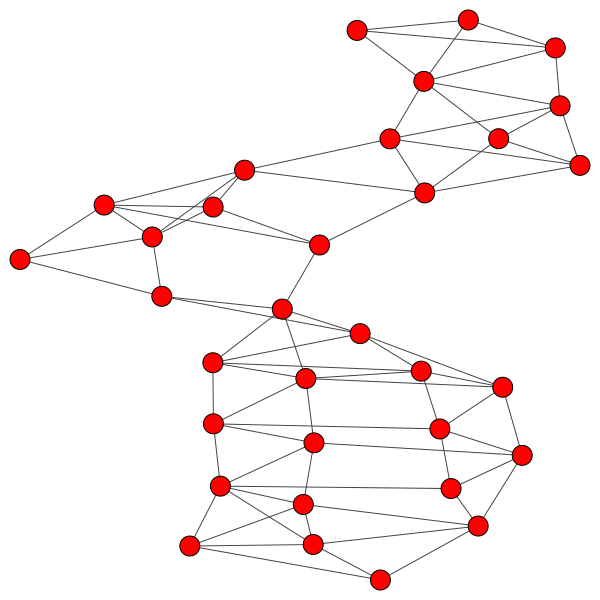

In [66]:
dt = np.load("wrong_graphs.npy", allow_pickle=True)
type(dt)

graph = ig.Graph.Adjacency(dt[2], mode='undirected')
ig.plot(graph)

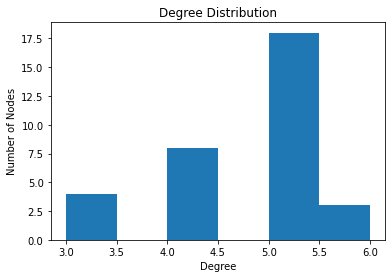

In [67]:
# plot degree distribution
bins = graph.maxdegree()
plt.hist(graph.degree(), bins)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()


In [5]:
vcount = graph.vcount()

cliques = graph.clique_number()
max_deg = graph.maxdegree()
min_degree = min(graph.degree())
avg_deg = np.average(graph.degree())
assortativity = graph.assortativity_degree()

graph.density(loops=True)
avg_neighbor_deg = np.average(np.array(graph.knn()[0]))
# graph.knn()[1] knn for each node degree.  The zeroth element of this list corresponds to vertices of degree 1.


62
28


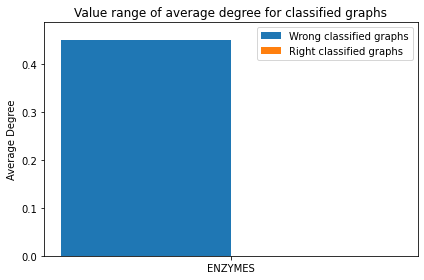

In [72]:
data_wrong_class = np.load("wrong_graphs.npy", allow_pickle=True)
wrong_class_array = get_cna_metrics(data_wrong_class)
print(len(wrong_class_array))

data_right_class = np.load("right_graphs.npy", allow_pickle=True)
correct_class_array = get_cna_metrics(data_right_class)
print(len(correct_class_array))

plot_value_range(wrong_class_array, correct_class_array, 5)
